# Hyperparameter Tuning

Grid search and Random search are automated ways of tuning different hyperparameters. Both require a grid to sample from (which hyperparameter-value combinations), a cross-validation scheme, and a scoring function.

## Setup

In [145]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe

In [146]:
df = pd.read_csv('diabetes.csv')
df.head()

,age,bmi,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,activity_level,family_history,smoking_status,diet_score,diabetes_risk
0,56,33.4,159,79,205,151,358,1,0,10,1
1,69,27.5,135,104,245,146,219,0,0,9,0
2,46,43.0,132,66,224,145,105,0,0,10,0
3,32,41.0,110,73,292,107,374,0,1,6,0
4,60,16.4,112,68,181,140,69,1,1,7,0


## Train, test, split

In [147]:
X = df.drop('diabetes_risk', axis=1)
y = df['diabetes_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Grid Search
Grid Search exhaustively tries all combinations within the sample space. No sampling methodology is necessary.

Grid Search is computational expensive, but guaranteed to find the best score in the sample space.

## Manual Grid Search

In [148]:
def gbm_grid_search(learn_rate, max_depth):
    model = GradientBoostingClassifier(
        learning_rate=learn_rate,
        max_depth=max_depth,
    )
    predictions = model.fit(X_train, y_train).predict(X_test)
    return [learn_rate, max_depth, accuracy_score(y_test, predictions)]

In [149]:
learn_rates = [0.001, 0.01, 0.05]
max_depths = [4,6,8,10]
results_list = []

for learn_rate in learn_rates:
    for max_depth in max_depths:
        results_list.append(gbm_grid_search(learn_rate, max_depth))

results_df = pd.DataFrame(results_list, columns=['learn_rate', 'max_depth', 'accuracy'])

results_df

,learn_rate,max_depth,accuracy
0,0.001,4,0.755
1,0.001,6,0.790
2,0.001,8,0.855
3,0.001,10,0.865
4,0.010,4,0.920
5,0.010,6,0.865
6,0.010,8,0.825
7,0.010,10,0.850
8,0.050,4,0.955
9,0.050,6,0.895


## Grid Search with Scikit Learn

Three steps.
1. Select an algorithm to tune the hyperparameters (sometimes referred to as an estimator)
2. Define hyperparameters to tune
3. Define range of values for hyperparameters
4. Set a cross-validation scheme and scoring function

## Create a GridSearchCV object

In [150]:
# create the grid
param_grid= {'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 4, 6]}

# create a base classifier
rf_class = RandomForestClassifier(criterion='entropy', max_features=None)

grid_rf_class = GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=4,
    cv = 10,
    refit=True, # enables direct use of the object as an estimator
    return_train_score=True
)

# fit the estimator to the data
grid_rf_class.fit(X_train, y_train)

# make predictions
predictions = grid_rf_class.predict(X_test)

# calculate accuracy
print(accuracy_score(y_test, predictions))

0.93


## Analyze GridSearchCV output

GridSearchCV properties

Results log:
- cv_results_

Best results:
- best_index_, best_params_, best_score_

Extra information:
- scorer_, n_splits_, refit_time_

### cv_results_

In [151]:
results = grid_rf_class.cv_results_ # A dictionary of results for each model created
results_df = pd.DataFrame(results)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.090611,0.001024,0.003121,0.000180,2,1,"{'max_depth': 2, 'min_samples_leaf': 1}",0.6750,0.7875,0.750,...,0.808333,0.822222,0.838889,0.837500,0.830556,0.826389,0.833333,0.841667,0.825278,0.014066
1,0.089449,0.000844,0.002961,0.000034,2,2,"{'max_depth': 2, 'min_samples_leaf': 2}",0.6750,0.8125,0.750,...,0.800000,0.815278,0.823611,0.833333,0.843056,0.823611,0.851389,0.854167,0.824583,0.019809
2,0.089247,0.000551,0.002808,0.000064,2,4,"{'max_depth': 2, 'min_samples_leaf': 4}",0.6875,0.7750,0.750,...,0.801389,0.820833,0.787500,0.823611,0.806944,0.829167,0.848611,0.840278,0.811806,0.023400
3,0.089657,0.000637,0.002945,0.000095,2,6,"{'max_depth': 2, 'min_samples_leaf': 6}",0.7125,0.8125,0.725,...,0.801389,0.819444,0.815278,0.847222,0.813889,0.837500,0.843056,0.837500,0.825278,0.014943
4,0.138373,0.000505,0.003133,0.000031,4,1,"{'max_depth': 4, 'min_samples_leaf': 1}",0.8500,0.8250,0.875,...,0.925000,0.931944,0.931944,0.951389,0.941667,0.937500,0.923611,0.933333,0.934722,0.009213


## Random Search
Random Search randomly selects a subset of combinations within the provided sample space. Uniform is the default sampling methodology, though others can be selected.

Random Search is less computationally expensive, but likely to find a *good* one *faster*.

### Manual Random Search

In [152]:
# set hyperparameter limits
learn_rates_list = np.linspace(0.001, 2, 150)
min_samples_leaf_list = list(range(1,51))

# create a list of combinations
combinations_list = [list(x) for x in product(learn_rates, min_samples_leaf_list)]

# randomly select 100 models
random_combinations_index = np.random.choice(
    range(0,len(combinations_list)), 100,
    replace=False)

selected_combinations = [combinations_list[x] for x in random_combinations_index]
print(selected_combinations)

[[0.05, 26], [0.001, 44], [0.05, 42], [0.01, 39], [0.001, 2], [0.01, 12], [0.001, 45], [0.01, 1], [0.01, 25], [0.05, 33], [0.01, 31], [0.05, 7], [0.01, 3], [0.01, 7], [0.001, 25], [0.05, 35], [0.001, 15], [0.05, 37], [0.01, 5], [0.05, 47], [0.01, 4], [0.05, 12], [0.001, 47], [0.01, 37], [0.001, 16], [0.01, 33], [0.01, 18], [0.05, 38], [0.01, 47], [0.01, 6], [0.01, 20], [0.05, 15], [0.01, 23], [0.001, 46], [0.001, 50], [0.001, 18], [0.05, 31], [0.05, 5], [0.001, 32], [0.01, 26], [0.001, 37], [0.001, 29], [0.01, 24], [0.05, 36], [0.01, 38], [0.01, 50], [0.01, 44], [0.05, 40], [0.01, 28], [0.05, 30], [0.05, 32], [0.001, 27], [0.01, 45], [0.001, 42], [0.05, 34], [0.01, 42], [0.01, 36], [0.01, 27], [0.01, 43], [0.05, 2], [0.001, 43], [0.05, 41], [0.001, 40], [0.01, 2], [0.01, 15], [0.05, 48], [0.01, 46], [0.01, 9], [0.05, 6], [0.001, 4], [0.001, 49], [0.05, 4], [0.05, 21], [0.001, 9], [0.001, 48], [0.01, 21], [0.01, 13], [0.001, 1], [0.05, 43], [0.001, 17], [0.001, 35], [0.05, 1], [0.001, 1

### Random Search with Scikit Learn

When working with RandomSearchCV, there is only one extra step compared to GridSearchCV: decide the number of samples to take.

In [153]:
random_rf_class = RandomizedSearchCV(
    estimator=rf_class,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    n_jobs=4,
    refit=True,
    return_train_score=True,
    random_state=11,
    cv=5
)

random_rf_class.fit(X_train, y_train)
predictions = random_rf_class.predict(X_test)
print(accuracy_score(y_test, predictions))

0.93


Key differences between GridSearchCV and RandomizedSearchCV:
- n_iter takes the number of samples for the random search to take from the grid
- param_distributions allows for the optional ability to set a distribution for sampling.

## Visualize results

In [154]:
random_rf_class.cv_results_

{'mean_fit_time': array([0.16104112, 0.0861218 , 0.12832799, 0.15164323, 0.14621048,
        0.12998443, 0.12866364, 0.15318995, 0.0849297 , 0.1596868 ]),
 'std_fit_time': array([0.00142165, 0.00096709, 0.00069453, 0.00169647, 0.001484  ,
        0.00050127, 0.00073903, 0.00131708, 0.00011182, 0.00303596]),
 'mean_score_time': array([0.00349612, 0.00318618, 0.00349255, 0.00365448, 0.00362525,
        0.00340881, 0.00334253, 0.00364466, 0.00306063, 0.00359797]),
 'std_score_time': array([7.83420958e-05, 8.82323222e-05, 1.54622667e-04, 1.20378860e-04,
        9.20319927e-05, 4.31408784e-05, 7.96031900e-05, 6.70859891e-05,
        5.51781982e-05, 4.56340883e-05]),
 'param_min_samples_leaf': masked_array(data=[1, 6, 4, 4, 6, 1, 2, 4, 4, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_max_depth': masked_array(data=[6, 2, 4, 6, 8, 4, 4, 8, 2, 8],
              mask=[False, False, False, Fal

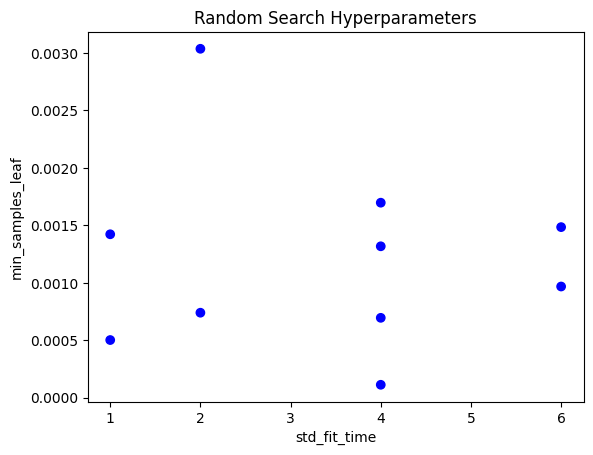

In [155]:
rand_x = list(random_rf_class.cv_results_['std_fit_time'])
rand_y = list(random_rf_class.cv_results_['param_min_samples_leaf'])

x_lims = [np.min(learn_rates_list), np.max(learn_rates_list)]
y_lims = [np.min(min_samples_leaf_list), np.max(min_samples_leaf_list)]

plt.scatter(rand_y, rand_x, c=['blue']*10)
plt.gca().set(xlabel='std_fit_time', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
plt.show()


## Considerations
Random search may be more valuable than Grid Search if:
- There is a large quantity of data
- There are a large number of hyperparameter-value combinations
- There is limited computational resources

## Informed Search

**Coarse to Fine Tuning:** Start with a rough, random approach and iteratively refine the search. This leverages and balances the benefits provided by Grid Search and Random Search.

Process:
1. Random search
2. Find promising areas
3. Grid search the smaller area
4. Continue until optimal score obtained


## Hyperopt

A package that leverages Bayes Rule to iteratively update hyperparameter tuning during the learning process.

**Bayes Rule:**
A method of using new evidence to updates beliefs about some outcome.

**Formula:**
P(A | B) = ( P(B | A) * P (A) ) / P(B)

**Explanation:**
- LHS: Probably of A, given B. B is some new evidence (*posterior*)
- RHS: Means of calculation
- P(A): the probability of the event based on past evidence (*prior*)
- P(B): the probability of observing this new evidence. (*marginal likelihood*)
- P(B | A): the probability of observing the evidence, given the event in question (*likelihood*)

**Process:**
1. Set the domain grid
2. Set the optimization algorithm (TPE by default)
3. Objective function to minimize

### The Domain

In [159]:
# quniform provides a uniform distribution that is quantized (binned) by the third argument
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 8, 2),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1)
}

### The Objective Function

In [160]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate']
    }

    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params)

    best_score = cross_val_score(gbm_clf, X_train, y_train,
                                 scoring='accuracy', cv=2, n_jobs=4).mean()
    loss = 1 - best_score
    return loss

### Run the algorithm

In [ ]:
best_result = fmin(
    fn=objective,
    space=space,
    max_evals=500,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest
)
print(best_result)

 17%|█▋        | 87/500 [00:09<00:40, 10.12trial/s, best loss: 0.03875000000000006] 